In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import humanize
import matplotlib.pyplot as plt 
import pickle
from ast import literal_eval

In [10]:
def save_as_pickle(file_path, file):
    with open(file_path, 'wb') as f:
        pickle.dump(file, f)

def load_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        file = pickle.load(f)
    return file

def dropunamed(df):
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    return df

def print_df(df, target_col = None):
    print(f"df.shape: {df.shape}")
    print(f"df.columns: {df.columns}")
    print(f"df size: {humanize.naturalsize(df.memory_usage().sum())}")
    if not target_col==None:
        print(df['target'].value_counts())
        
def get_extension_files(path_to_json, ext='.json'):
    json_files = [os.path.join(path_to_json, pos_json) for pos_json in os.listdir(path_to_json) if pos_json.endswith(ext)]
    return json_files    

def get_local_vedio_path(row):
    local_base_dir = row["local_base_dir"]
    stem_dir_list = row["vedio_path"].split("/")[5:]
    stem_path = os.path.join(*stem_dir_list)
    return os.path.join(local_base_dir, stem_path)

def change_vedio_path(df, base_dir):
    df["local_base_dir"] = [base_dir]*df.shape[0]
    df["vedio_path"] = df.apply(get_local_vedio_path, axis=1)
    df = df.drop("local_base_dir", axis=1)
    return df

def get_list_from_string(strn):
    return literal_eval(strn.replace("\n", "").replace("\' \'", "\', \'"))

def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def get_img_list_list(img_path_list_list, resize_shape=(50,50)):
    img_list_list = []
    for img_path_list in img_path_list_list:
        img_list=[]
        for img_path in img_path_list:
            img = cv2.imread(img_path)
            img = img[:, :, ::-1]
            if resize_shape is not None:
                img = cv2.resize(img, resize_shape)
            img_list.append(img)
        img_list_list.append(img_list)
    return img_list_list

def show_collage(img_path_list_list = None, img_list_list = None, title=None, resize_shape=(50,50), figsize=(12,12)):
    vertical_images=[]
    if img_list_list is None:
        img_list_list = get_img_list_list(img_path_list_list)
            
    for img_list in img_list_list:
        images=[]
        for img in img_list:
            if resize_shape is not None:
                img=cv2.resize(img, resize_shape)
            hside=get_side(img, side_type="horizontal")
            images.append(img)
            images.append(hside)
        himage=np.hstack((images))
        vside=get_side(himage, side_type="vertical")
        vertical_images.append(himage)
        vertical_images.append(vside)

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.imshow(gallery.astype(np.uint8))
    
def plt_subplots(img_path_list_list = None, img_list_list = None, 
                 title=None, title_list_list=None, 
                 resize_shape=(50,50), figsize=(12,12)):
            
    if img_list_list is None:
        img_list_list = get_img_list_list(img_path_list_list)
        
    if title_list_list is None:
        title_list_list=[]
        for img_list in img_list_list:
            title_list_list.append([None]*len(img_list))
        
    fig = plt.figure()
    rows = len(img_list_list)
    cols = max([len(w) for w in img_list_list])
    print(f"(rows, cols): {rows, cols}")
    for i, (img_list, title_list) in enumerate(zip(img_list_list, title_list_list)):
        images=[]
        for j, (img, title) in enumerate(zip(img_list, title_list)):
            ax = fig.add_subplot(rows, cols, i*cols+j+1)
            imgplot = plt.imshow(img)
            if title is not None:
                ax.set_title(title)

def imshow_frames(df, vname=None, vedio_path=None, frame_index_list=None, pred_prof_name=None, 
                  collage=True, max_cnt = 20, img_per_row = 5,
                  show_miss=False, show_correct=False):
    
    if vedio_path is None:
        vedio_path = df[df["vname"]==vname].iloc[0]["vedio_path"]
        
    df = df[df["vedio_path"]==vedio_path].iloc[0]
    name_list = get_list_from_string(df["names_list"])
    true_name = df["true_name"]
    
    if frame_index_list is None:
        frame_index_list = get_list_from_string(df["frame_index_list"])

    if pred_prof_name is not None:
        filter_list = [i for i,n in enumerate(name_list) if n==pred_prof_name]
        frame_index_list = [w for i,w in enumerate(frame_index_list) if i in filter_list]
        name_list = [w for i,w in enumerate(name_list) if i in filter_list]
        
    if not show_miss or not show_correct:
        if show_miss:
            filter_list = [i for i,n in enumerate(name_list) if n!=true_name]
            frame_index_list = [w for i,w in enumerate(frame_index_list) if i in filter_list]
            name_list = [w for i,w in enumerate(name_list) if i in filter_list]
        else:
            filter_list = [i for i,n in enumerate(name_list) if n==true_name]
            frame_index_list = [w for i,w in enumerate(frame_index_list) if i in filter_list]
            name_list = [w for i,w in enumerate(name_list) if i in filter_list]
        
    print(f"frame_index_list: {frame_index_list}")
    title_list_list = [name_list[i:i + img_per_row] for i in range(0, len(name_list), img_per_row)]
    vname = vedio_path.split('\\')[-1]
    video_capture = cv2.VideoCapture(vedio_path)
    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    img_list=[]
    img_list_list = []
    i=-1
    cnt=0
    total_cnt=0
    while video_capture.isOpened():
        i+=1
        if int(i/fps) not in frame_index_list:
            ret, frame = video_capture.read()
            continue

        if int(i/fps) > max(frame_index_list):
            break
        
        ret, frame = video_capture.read()
        if i%fps==0:
            print(int(i/fps))
            frame = frame[:, :, ::-1]
            img_list.append(frame)
            cnt+=1
            total_cnt+=1
            if cnt%img_per_row==0:
                img_list_list.append(img_list)
                cnt=0
                img_list=[]
            
            print(f"total_cnt: {total_cnt}")
            if total_cnt>max_cnt or total_cnt>=len(frame_index_list):
                break
            
    if not collage:
        plt_subplots(img_list_list=img_list_list, title_list_list=title_list_list)
    else:
        show_collage(img_list_list=img_list_list, resize_shape=(300,300)) 
        
def imshow_labelled_faces_of_predictions(df, vname, 
                                         collage=False, num_img_per_prof = 3, 
                                         resize_shape = (50, 50)):
    prof_names_list = get_list_from_string(df[df["vname"]==vname]["unique"].iloc[0])
    
    title = f"{num_img_per_prof} labeled faces per predicted professor"
    img_path_list_list=[]
    title_list_list=[]
    for prof_name in prof_names_list:
        folder_name = prof_name_2_folder_name_dict[prof_name]
        folder_path = os.path.join(known_faces_dir, str(folder_name))
        img_path_list = get_extension_files(folder_path, ext=".jpg")[:num_img_per_prof]
        img_path_list_list.append(img_path_list)
        title_list_list.append([prof_name]*len(img_path_list))
    
    if not collage:
        plt_subplots(img_path_list_list = img_path_list_list, title_list_list=title_list_list)
    else:
        show_collage(img_path_list_list = img_path_list_list, title = title)

In [3]:
base_dir = 'D:\\nptel_face_recognition'
data_dir = os.path.join(base_dir, 'data')
known_faces_dir = os.path.join(data_dir, 'known_faces')
full_vedios_dir = os.path.join(data_dir, 'full_vedio')
pkl_files_dir = os.path.join(data_dir, "pkl_files")
csv_files_dir = os.path.join(data_dir, "csv_files")

folder_name_2_prof_name_dict = load_from_pickle(os.path.join(pkl_files_dir, "folder_name_2_prof_name_dict.pkl"))
prof_name_2_folder_name_dict = {v: k for k, v in folder_name_2_prof_name_dict.items()}


In [27]:
# df = pd.read_csv(os.path.join(csv_files_dir, "face_recognition_results.csv"))
df = pd.read_csv(os.path.join(csv_files_dir, "face_recognition_results_with_diversity.csv"))
df = dropunamed(df)
df = change_vedio_path(df, base_dir)
# while reading csv files lists have to be converted locally using get_list_from_string  
# takes 1 minute to load the pickle file
# df = pd.read_pickle(os.path.join(pkl_files_dir, "face_recognition_results.pkl"))


In [17]:
print_df(df)

df.shape: (33, 18)
df.columns: Index(['vname', 'nptel_channel_name', 'playlistn', 'vedio_path', 'true_name',
       'accuracy', 'number of predictions', 'time', 'unique', 'counts',
       'frame_index_list', 'names_list', 'slides_index_list_0.3',
       'slides_index_list_0.4', 'slides_index_list_0.5',
       'slides_index_list_0.6', 'slides_index_list_0.7',
       'slides_index_list_0.8'],
      dtype='object')
df size: 4.9 kB


In [18]:
df.head()

,vname,nptel_channel_name,playlistn,vedio_path,true_name,accuracy,number of predictions,time,unique,counts,frame_index_list,names_list,slides_index_list_0.3,slides_index_list_0.4,slides_index_list_0.5,slides_index_list_0.6,slides_index_list_0.7,slides_index_list_0.8
0,ZDQBcuVRWYs.mp4,Aerospace Engineering,Jet and Rocket Propulsion,D:\nptel_face_recognition\data\full_vedio\Aero...,dr. a. kushari,0.90,50,23.459062,['dr. a. kushari' 'dr. p. gopinath ' 'prof. s....,[45 1 2 1 1],"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","['dr. a. kushari', 'dr. a. kushari', 'dr. a. k...","[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, ..."
1,QLcxx6MJnbA.mp4,Aerospace Engineering,Jet and Rocket Propulsion,D:\nptel_face_recognition\data\full_vedio\Aero...,dr. a. kushari,0.86,50,17.181391,['dr. a. kushari' 'prof. s. dasgupta' 'prof. s...,[43 2 2 3],"[16, 17, 18, 19, 20, 21, 40, 41, 42, 43, 44, 4...","['dr. a. kushari', 'dr. a. kushari', 'dr. a. k...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ..."
2,YrkbOeF7wFw.mp4,Aerospace Engineering,Jet and Rocket Propulsion,D:\nptel_face_recognition\data\full_vedio\Aero...,dr. a. kushari,0.30,50,33.226010,['dr. a. kushari' 'dr. p. gopinath ' 'prof. am...,[15 3 1 1 1 1 9 19],"[16, 17, 18, 19, 20, 21, 22, 23, 24, 42, 43, 4...","['dr. a. kushari', 'dr. a. kushari', 'prof. t....","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ...","[0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, ..."
3,_9qwbichO1s.mp4,Aerospace Engineering,Introduction to Aerodynamics,D:\nptel_face_recognition\data\full_vedio\Aero...,prof. k. p. sinhamahapatra,0.98,50,13.712542,['prof. k. p. sinhamahapatra' 'prof. t.k.sengu...,[49 1],"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","['prof. k. p. sinhamahapatra', 'prof. t.k.seng...","[4, 5, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 12, 13, 1...","[4, 5, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 12, 13, 1...","[4, 5, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 12, 13, 1...","[4, 5, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 12, 13, 1...","[4, 5, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 12, 13, 1...","[4, 5, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 12, 13, 1..."
4,BhWzgo7qkbE.mp4,Aerospace Engineering,Introduction to Aerodynamics,D:\nptel_face_recognition\data\full_vedio\Aero...,prof. k. p. sinhamahapatra,1.00,45,34.547672,['prof. k. p. sinhamahapatra'],[45],"[20, 21, 22, 23, 24, 25, 26, 85, 86, 98, 99, 1...","['prof. k. p. sinhamahapatra', 'prof. k. p. si...","[5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10,...","[5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10,...","[5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10,...","[5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10,...","[5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10,...","[5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10,..."


In [25]:
acc_threshold = 0.95
print(f'total vedios: {df.shape[0]}\nmean acuracy: {df["accuracy"].mean()}\n\
num of nans: {df[df["accuracy"].isna()].shape[0]}\nper of perfect accuracy: {df[df["accuracy"]>=acc_threshold].shape[0]/df.shape[0]}')

total vedios: 52
mean acuracy: 0.7858143244962427
num of nans: 0
per of perfect accuracy: 0.5384615384615384


C:\Users\YASH\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\YASH\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 1.,  1.,  1.,  0.,  2.,  1.,  1.,  2.,  4., 19.]),
 array([0.14 , 0.226, 0.312, 0.398, 0.484, 0.57 , 0.656, 0.742, 0.828,
        0.914, 1.   ]),
 <BarContainer object of 10 artists>)

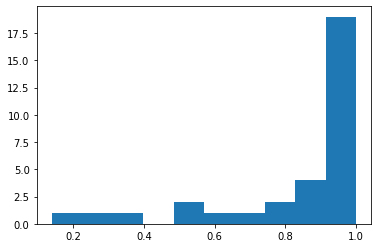

In [20]:
plt.hist(df["accuracy"])

In [ ]:
# show sample images for all predicetd profs for a vedio

# imshow_all_predictions(df, "Vnxy8BcCTUc.mp4")

In [43]:
def make_list_unique(x):
    return list(set(x))

def add_lists(list_list):
    final_list = []
    for listn in list_list:
        final_list+=listn
    return final_list
        
def get_common_elements_in_lists(list_list):
    final_list = add_lists(list_list)
    return len(final_list) - len(make_list_unique(final_list))

def merge_lists(list_list, unique=True):
    final_list = add_lists(list_list)
    if unique:
        final_list = make_list_unique(final_list)
    return final_list

threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

slides_index_list = []
for threshold in threshold_list:
    slides_index_list.append(df[f"slides_index_list_{threshold}"].apply(get_list_from_string).apply(foo))
frame_index_list = df["frame_index_list"].apply(get_list_from_string).apply(foo)

In [44]:
slides_frames=[[]*len(threshold_list)]*len(frame_index_list)
for i in range(len(frame_index_list[:1])):
    frame_index = frame_index_list[i]
    max_idx = max(frame_index)
    all_frames = list(range(max_idx))
    for j in range(len(slides_index_list)):
        threshold = threshold_list[j]
        slides_index = slides_index_list[0]
        
        slides_frames = merge_lists([frame_index, slides_index])
        print(f"for threshold {threshold}\nper common elements: {get_common_elements_in_lists([frame_index, slides_index])}\
        \nper elements covered: {len(slides_frames)/len(all_frames)}")
        

ValueError: operands could not be broadcast together with shapes (50,) (33,) 